In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [33]:
translation_rates = [[[[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]],#Transition from V to V based on V,R,C neighbor
                     [[0,0,0,0,0,0],[ 2, 1.5, 1, 0.5,0.5,0.1],[-2,2, 1, 0.4, 0.1, 0]],#Transition from V to R based on V,R,C neighbor
                     [[0,0,0,0,0,0],[4, 3,2, 1.5, 1, 1],[25, 25, -1, -1, -1, -1]]],#Transition from V to C based on V,R,C neighbor
                     [[[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]],#Transition from R to V based on V,R,C neighbor
                     [[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]],#Transition from R to R based on V,R,C neighbor
                     [[0,0,0,0,0,0],[25, 25, -2, -2, -2, -2],[4, 3, 2, 1.5, 1, 1]]],#Transition from R to C based on V,R,C neighbor
                     [[[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]],#Transition from C to V based on V,R,C neighbor
                     [[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]],#Transition from C to R based on V,R,C neighbor
                      [[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]]]]#Transition from C to C based on V,R,C neighbor


def mincelfun(inarr, params = 3,preservance = 1,perturbation=2.5):
    """
    The function takes a timeslice of the array and calculates of proportions of each neighbour in Moore neighbourhood.
    """
    retprob = np.zeros(params)
    totsum = 0
    map_center = int(math.floor(len(inarr)/2))
    center_param = int(inarr[map_center][map_center][0])
    retprob[center_param] = preservance
    for i, rowarr in enumerate(inarr):
        for j, val in enumerate(rowarr):
            mooredist = min([abs(i-map_center),abs(j-map_center)])-1
            if mooredist ==0:
                continue
            n_param = int(val[0])
            translations = [translation_rates[center_param][towards][n_param][mooredist]for towards in range(params)]
            retprob += translations # Uses value to index type of cell and increase value in prob array.
    if (totsum <= 0): # Is this correct? totsum is only 0 if the function is passed an empty matrix. 
        retprob = np.zeros(params)
        retprob[center_param] = 1
        return retprob
    negative_part = 0
    for g in range(params):
        if retprob[g]<0:
            retprob[g]=0
        else:
            stochastic_perturbation = 1 + (-1* np.log(np.random.rand()))
            retprob[g] = stochastic_perturbation * retprob[g]
    
    totsum = sum(retprob)
    return retprob / float(totsum)



def mincelfunbkp(inarr, params = 3):
    """
    The function takes a timeslice of the array and calculates of proportions of each neighbour in Moore neighbourhood.
    """
    retprob = np.zeros(params)
    totsum = 0
    map_center = int(math.floor(len(inarr)/2))
    center_param = int(inarr[map_center][map_center][0])
    for i, rowarr in enumerate(inarr):
        for j, val in enumerate(rowarr):
            mooredist = min([abs(i-map_center),abs(j-map_center)])-1
            if mooredist ==0:
                continue
            n_param = int(val[0])
            translations = [translation_rates[center_param][towards][n_param][mooredist]for towards in range(params)]
            totsum += sum(translations) # Increases the total sum of cells that have some state
            retprob += translations # Uses value to index type of cell and increase value in prob array.
    if (totsum <= 0): # Is this correct? totsum is only 0 if the function is passed an empty matrix. 
        retprob = np.zeros(params)
        retprob[center_param] = 1
        return retprob
    negative_part = 0
    for g in range(params):
        if retprob[g]<0:
            totsum += (-1 *retprob[g])
            retprob[g]=0
    return retprob / float(totsum)

def CA_city(init_mat, moore_n = 6, params = 3, debug = False):
    """
    Loops through each cell and calculates its prob of changing state, then changes the state randomly.
    """
    # Assumes initmat is of shape N,N,2 
    init_dimx,init_dimy,init_pars = np.shape(init_mat)
    
    workgrid = np.zeros((init_dimx + 2 * moore_n, init_dimy + 2 * moore_n, init_pars))
    retgrid = init_mat.copy()
    workgrid[moore_n:-moore_n, moore_n:-moore_n] = init_mat
    # Loops through the matrix dimensions, calls mincelfun() to find the values of neighbour cells. 
    for i,rowarr in enumerate(init_mat):
        for j,val in enumerate(rowarr):
            probs = mincelfun(workgrid[i:i+1 + 2*moore_n,j:j+1+2*moore_n], params = params)
            increase_param = np.random.choice(list(range(params)), 1, p = probs)
            # if/else checks which value was randomly selected in previous line and updates matrix accordingly.
            if increase_param == 0:
                continue
            elif increase_param == workgrid[i+moore_n, j+moore_n, 0]:
                retgrid[i,j,1] += 1
            else:
                retgrid[i,j] = [increase_param,1]
    return retgrid


def init_grid(N,params):
    """
    The function creates the initial state of the matrix and sets its values.
    Takes the dimensions of the grid and parameters as arguments and returns initial condition of matrix.
    """
    retgrid = np.zeros((N,N,2))
    center = math.floor(N/2) # finds the center of the grid
    retgrid[:,:,1] = 1 # sets the center of the grid as a 1.
    retgrid[center,center,0] =1
    
    return retgrid

In [34]:
dimensions = 100
time = 15
solution_dev = np.empty((time,dimensions,dimensions,2))
init_city = init_grid(dimensions,3)
solution_dev[0] = init_city
solution_dev[1] = CA_city(solution_dev[0],moore_n=6)
for step in range(2,time):
    solution_dev[step] = CA_city(solution_dev[step-1],moore_n=6)
    

C:\Users\HP\AppData\Local\Temp\ipykernel_25144\1160040514.py:90: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  retgrid[i,j] = [increase_param,1]


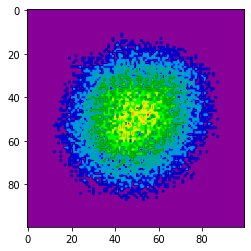

In [37]:
plt.imshow(solution_dev[9,:,:,1], cmap = 'nipy_spectral', vmin = 0, vmax = 10)

In [6]:
np.random.rand(5)

array([0.03920972, 0.92347685, 0.7095767 , 0.76797961, 0.94520181])

In [19]:
solution_dev[10,:,:,0]

array([[2., 2., 2., ..., 1., 1., 2.],
       [2., 2., 2., ..., 2., 2., 1.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]])